In [ ]:
# Instalación de paquetes
#  !pip install h5py pillow matplotlib scipy toolz snakeviz scikit-image dask distributed
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install fsspec

     |████████████████████████████████| 136 kB 8.0 MB/s 


# Paralelizar código con dask.delayed

In [ ]:
# Importar librerías
from dask.distributed import Client

# client = Client(n_workers=1)  # Cuántos "trabajadores" voy a usar

In [ ]:
# Defino dos funciones aquí:
# inc me va a incrementar en una unidad a x y el sistema se va a "dormir"  1 segundo
from time import sleep

def inc(x):
    sleep(2)
    return x + 1
# add va a sumar x y y
def add(x, y):
    sleep(2)
    return x + y

In [ ]:
add(x,y)

In [ ]:
%%time
# Este toma 3 segundos en correr porque llama a cada función secuencialmente. Una después de la otra.
x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 29.4 ms, sys: 1.75 ms, total: 31.2 ms
Wall time: 6.01 s


In [ ]:
from dask import delayed

In [ ]:
%%time
# Este se demora muchísimo menos

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 669 µs, sys: 0 ns, total: 669 µs
Wall time: 558 µs


In [ ]:
z

Delayed('add-3f98aebc-570d-47d0-98ee-429c06efbbc6')

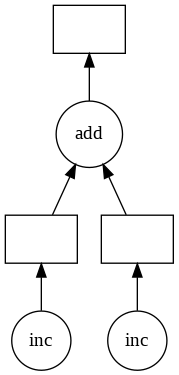

In [ ]:
# Esto me ayuda a ver lo que hizo dask
z.visualize()

## Paralelizando un loop "for"

In [ ]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)
# Este se demoró 16 segundos

CPU times: user 92.7 ms, sys: 8.54 ms, total: 101 ms
Wall time: 16 s


In [ ]:
%%time
results = []  # Creo una lista vacía
for x in data:
  y = delayed(inc)(x)  # sintaxis:  delayed(funcion)(dato)
  results.append(y)  # Voy añadiendo los términos en y
total = delayed(sum)(results)
# Este no tomó ni 1 segundo

CPU times: user 419 µs, sys: 934 µs, total: 1.35 ms
Wall time: 1.15 ms


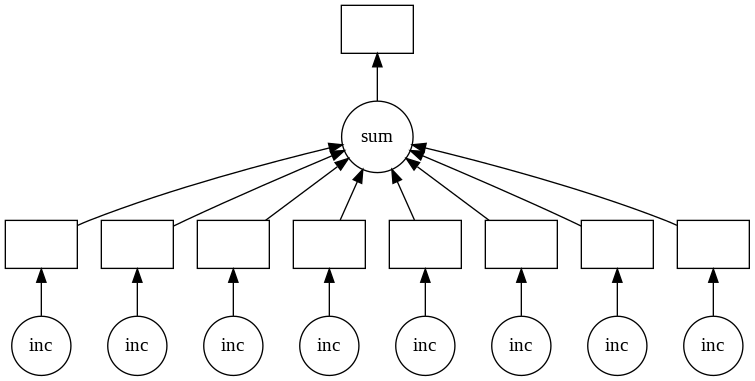

In [ ]:
total.visualize()
# Son 8 datos, a cada uno se le aplicó la función inc y finalmente se aplicó la función sum

## Paralelizando un loop for con estructuras de control

In [ ]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Se hará el siguiente ejercicio: Se creará un loop que evaluará si el número es par o no. Si es par, entonces a ese número se le multiplicará por 2 y se guardará en una lista (results). Si el número no es par, se le adicionará 1 unidad y de igual manera se guardará en la lista results.
Por último, se sumará el total de números que hay en la lista.

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)
# Dio como resultado 90. Se demoró 15 segundos.

90
CPU times: user 471 ms, sys: 74.4 ms, total: 545 ms
Wall time: 15 s


In [ ]:
## Ahora con programación en paralelo.
%%time
results = []
for x in data:
  if is_even(x):  # Aquí no puedo colocar el delayed porque lo que se evalúa es una condición booleana-
    y = delayed(double)(x)
  else:
    y = delayed(inc)(x)
  results.append(y)
total = delayed(sum)(results)
print(total)
# Demoró 9.5 milisegundos.

Delayed('sum-4406e9c3-cd32-4e5c-8a20-c5a49cd8328c')
CPU times: user 2.78 ms, sys: 782 µs, total: 3.56 ms
Wall time: 9.5 ms


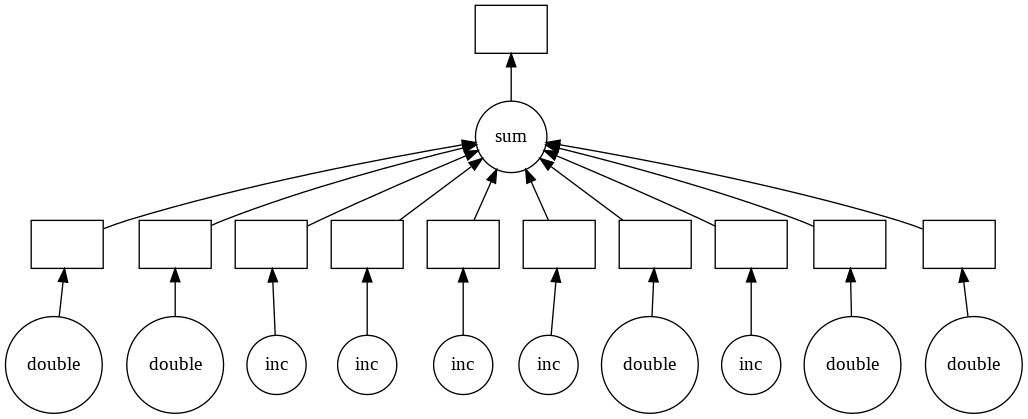

In [ ]:
total.visualize()
# 5 números son pares (se aplica double) y 5 números son impares (se aplica inc)

In [ ]:
@dask.delayed
def f(x):
  x += 1
  return x

Es bueno usar colecciones

In [ ]:
# Too many tasks
%%time
import dask
results = []
for x in range(10000000):
    y = dask.delayed(f)(x)
    results.append(y)
# Este demora mucho tiempo

In [ ]:
# Use collections
%%time
import dask.bag as db
b = db.from_sequence(range(10000000), npartitions=1000)
b = b.map(f)
# Demoró 9.19 segundos

CPU times: user 8.64 s, sys: 271 ms, total: 8.91 s
Wall time: 9.19 s


In [ ]:
for i in b:
  y = delayed(f)(b)
sum(y)

In [ ]:
import dask.delayed

In [ ]:
# Collect many calls for one compute
%%time
L = [1,2,3,4,5,6]
results = []
for x in L:
    y = dask.delayed(f)(x)
    results.append(y)
results = dask.compute(*results)
results

CPU times: user 1.88 ms, sys: 1 ms, total: 2.88 ms
Wall time: 4.55 ms


## Divida los cálculos en muchas partes

In [ ]:
# Correcto
# Break up into many tasks

@dask.delayed
def load(filename):
    ...

@dask.delayed
def process(filename):
    ...

@dask.delayed
def save(filename):
    ...


def f(filenames):
    results = []
    for filename in filenames:
        data = load(filename)
        data = process(data)
        result = save(data)

    return results

# dask.compute(f(filenames))